In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline
import sklearn.feature_selection
import pymatgen.io.ase
import pymatgen.symmetry.analyzer
import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path).fillna(0)

In [4]:
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn']
fblock = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
          'Ac', 'Th', 'Pa', 'U',  'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
d_synths = ['Rf', 'Db', 'Sg', 'Bh', 'HS', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']

bad_elements = noble_gases + fblock + d_synths

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomp_mask = data['decomposition_energy (eV/atom)'] < 0.5

exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

reasonable = data[element_mask & decomp_mask & exfol_mask]

In [5]:
pymatgen_objs = reasonable['atoms_object (unitless)'].progress_apply(pymatgen.io.ase.AseAtomsAdaptor.get_structure)
spacegroups = pymatgen_objs.progress_apply(lambda structure: pymatgen.symmetry.analyzer.SpacegroupAnalyzer(structure).get_space_group_number())

100%|██████████| 3511/3511 [00:02<00:00, 1345.84it/s]


In [6]:
max_bitlength = spacegroups.apply(lambda num: num.bit_length()).max()
bins = spacegroups.apply(lambda sg: np.base_repr(sg, base=2, padding=max_bitlength-sg.bit_length()))

spacegroup_colnames = [f'spacegroup_bit_{2**i}' for i in range(max_bitlength)]
reasonable[spacegroup_colnames] = bins.apply(list).apply(lambda lst: list(map(int,lst))).to_list()


/Users/mat3ra/sisso_collab/.env/lib/python3.9/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [7]:
cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'bandgap (eV)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
target_column = ['exfoliation_energy_per_atom (eV/atom)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

In [8]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'
]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

In [9]:
graph_descriptors = list(filter(lambda colname: any(i in colname for i in ["(bonds)", "(angles)", "(atoms)"]), reasonable.columns))

In [10]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [11]:
train_x_reg = np.nan_to_num(train[matminer_descriptors + spacegroup_colnames].to_numpy())
train_y_reg = np.nan_to_num(train[target_column].to_numpy())

test_x_reg = np.nan_to_num(test[matminer_descriptors + spacegroup_colnames].to_numpy())
test_y_reg = np.nan_to_num(test[target_column].to_numpy())

In [12]:
import sklearn.linear_model

current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_reg), train_y_reg, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg

    params = {

    }

    current_reg = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:squarederror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 10,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )
 
    return np.sqrt(score)

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize'
)

reg_study.optimize(func=objective, n_trials=256, callbacks=[keep_best_reg])

[I 2021-08-26 12:51:38,901] A new study created in memory with name: no-name-21fc77ce-34c0-4dbb-882a-958baf0d0fb8
[I 2021-08-26 12:51:39,090] Trial 0 finished with value: 0.0808568551464411 and parameters: {'max_depth': 20, 'min_child_weight': 6.221087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.0808568551464411.
[I 2021-08-26 12:51:39,288] Trial 1 finished with value: 0.08050798355817151 and parameters: {'max_depth': 78, 'min_child_weight': 2.7259260528264164, 'alpha': 1.3823212757154835, 'lambda': 4.009360887675096}. Best is trial 1 with value: 0.08050798355817151.
[I 2021-08-26 12:51:39,296] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2021-08-26 12:51:39,305] Trial 3 pruned. Trial was pruned at iteration 1.
[I 2021-08-26 12:51:39,314] Trial 4 pruned. Trial was pruned at iteration 1.
[I 2021-08-26 12:51:39,457] Trial 5 finished with value: 0.07999243342629636 and parameters: {'max_depth': 37, 'min_child_weight': 6.1539617

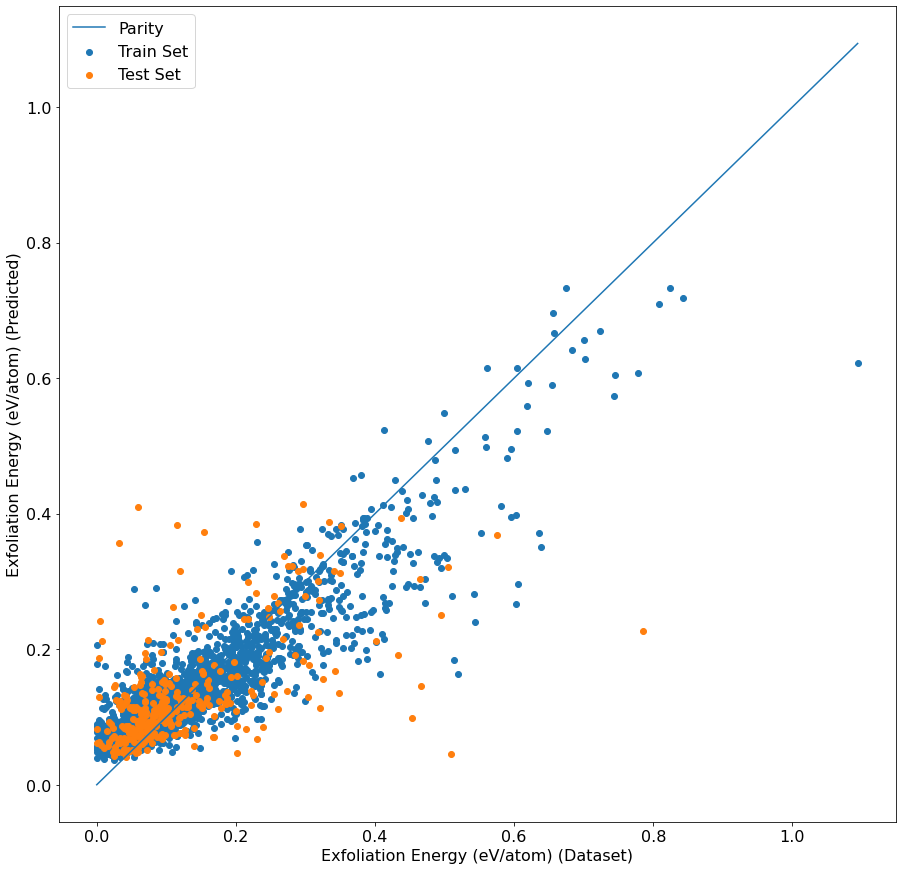

In [13]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_reg,
                                                test_x_reg,
                                                train_y_reg,
                                                test_y_reg,
                                                best_reg,
                                                "Exfoliation Energy (eV/atom)",
                                                "exfoliation_parity.jpeg")

In [14]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_reg.predict(test_x_reg)
for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 0.559
MAE 0.054
MSE 0.008
RMSE 0.087
MAPE 3.603
R2 0.328


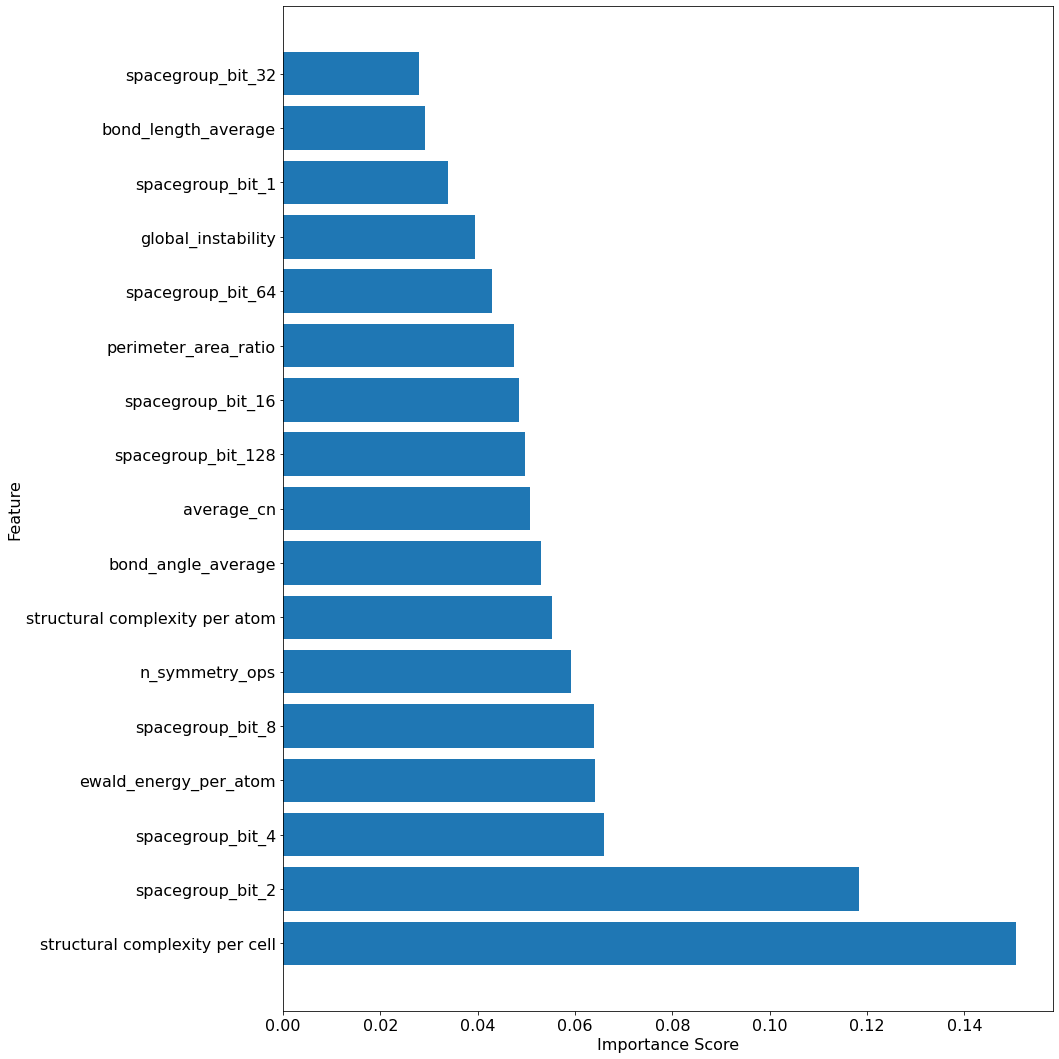

In [15]:
n_importances = len(matminer_descriptors + spacegroup_colnames)
importances = list(zip(best_reg[1].feature_importances_, matminer_descriptors+spacegroup_colnames))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("sg_importances.jpeg")